# scTensor

1. 概要
2. インストール方法
3. 入力データの詳細
4. scTensorの実行
5. 出力データの見方

## 1. 概要

scTensorでは、
1. シングルセルデータとリガンドー受容体結合情報から細胞間相互作用(CCI : cell-cell intaraction)を検出する。
2. テンソル分解によって、関連性の高いリガンドー受容体ペアを推定する
3. 解析結果をHTMLレポートとして出力する
R/Bioconductorパッケージ（Rのバーションは3.6以上が必要）  
インストールの詳細　→ [github(rikenbit/scTensor)](https://github.com/rikenbit/scTensor)  
使い方の詳細→[日本語の説明](https://colab.research.google.com/github/kokitsuyuzaki/SakigakeMTG2019/blob/master/exercise2/exercise2_scTensor.ipynb#scrollTo=PpV2es3c4q57)、[bioconductor](https://bioconductor.org/packages/release/bioc/html/scTensor.html)  
論文→[Koki Tsuyuzaki, Manabu Ishii, Itoshi Nikaido(2019)(bioRxiv: preprint)](https://doi.org/10.1101/566182)

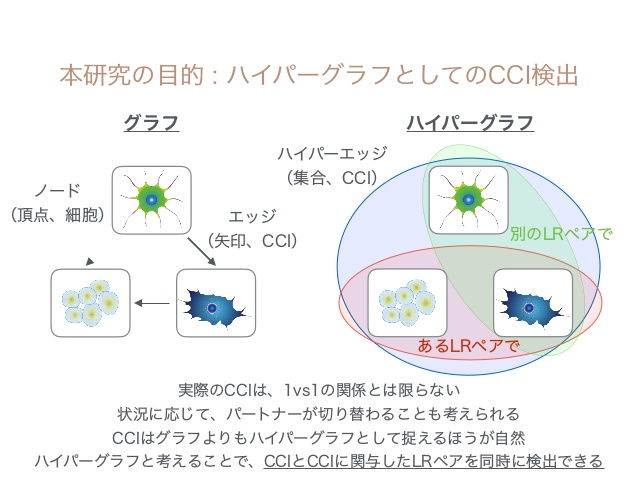

[参考スライド](https://www.slideshare.net/antiplastics/ss-115928123)

**入力データ**： scTensorには[Li, Li et al., 2017, Cell](https://www.sciencedirect.com/science/article/pii/S1934590917300784?via%3Dihub)でのデータの一部をdemoデータとして呼び出せる。
1. **発現量のmatrix**: demoデータはdata(GermMale)
2. **細胞型ラベル**: demoデータはdata(labelGermMale) 
3. Rtsne（Rパッケージ）の出力結果、つまり、**t-SNEによって次元削減した二次元座標**: demoデータはdata(tsneGermMale) 

これらのデータは、scTensorに読み込む前に、SingleCellExperiment（Rパッケージ）で処理した**SingleCellExperimentオブジェクト**にする必要がある。
  
**出力データ**:
細胞間相互作用（CCI)を示したhtml形式のレポート

## 2. インストールの方法

In [5]:
# パッケージインストール
# ここの処理は時間がかかる。
install.packages(c("BiocManager", "IRdisplay"), repos="http://cran.r-project.org")
BiocManager::install(c("SingleCellExperiment", "LRBase.Hsa.eg.db", "MeSH.Hsa.eg.db"), suppressUpdates=TRUE)
remotes::install_github("rikenbit/scTensor")

Installing packages into ‘/home/oba/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'SingleCellExperiment', 'LRBase.Hsa.eg.db',
  'MeSH.Hsa.eg.db'

Installation path not writeable, unable to update packages: googleVis, httpuv,
  later, liger, nnTensor, rsample, vctrs, lubridate, SQUAREM





✔  checking for file ‘/tmp/Rtmp1I231c/remotes186ca6db3485/rikenbit-scTensor-8673cf6/DESCRIPTION’
─  preparing ‘scTensor’:
✔  checking DESCRIPTION meta-information
─  installing the package to process help pages
─  saving partial Rd database (1m 4.7s)
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘scTensor_1.4.0.tar.gz’
   


Installing package into ‘/home/oba/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)



[SingleCellExperiment](https://bioconductor.org/packages/release/bioc/html/SingleCellExperiment.html) シングルセルデータをまとめる形式(細胞は列、特徴（遺伝子、転写物、ゲノム領域）が行でまとめる。次元削減の結果をまとめることもできる。)  
downloaded 1.5 MB

[LRBase.Hsa.eg.db](http://bioconductor.org/packages/release/data/annotation/html/LRBase.Hsa.eg.db.html) : Homo sapiens リガンド-受容体遺伝子のペアリスト、他の生物のデータを使うこともできる。  
downloaded 1.4 MB

[MeSH.Hsa.eg.db](https://bioconductor.org/packages/release/data/annotation/html/MeSH.Hsa.eg.db.html) : Homo sapiens MeSH IDとEntrez Gene IDのアノテーションデータ  
downloaded 488.8 MB

In [1]:
# パッケージロード
library("scTensor")
library("SingleCellExperiment")
library("LRBase.Hsa.eg.db") 
library("MeSH.Hsa.eg.db")
library("IRdisplay")

Registered S3 method overwritten by 'seriation':
  method         from 
  reorder.hclust gclus





Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lap

In [2]:
dbInfo(LRBase.Hsa.eg.db)

NAME,VALUE
<chr>,<chr>
SOURCEDATE,7-Oct-2019
SOURCENAME1,SWISSPROT
SOURCENAME2,TREMBL
SOURCENAME3,STRING
SOURCEURL1,http://www.uniprot.org/uniprot/?query=reviewed:yes
SOURCEURL2,http://www.uniprot.org/uniprot/?query=reviewed:no
SOURCEURL3,https://string-db.org/cgi/download.pl
DBSCHEMA,LRBase.Hsa.eg.db
DBSCHEMAVERSION,1.2.0


## 3. 入力データの詳細

1. **発現量のmatrix**: demoデータはdata(GermMale)
2. **細胞型ラベル**: demoデータはdata(labelGermMale) 
3. Rtsne（Rパッケージ）の出力結果、つまり、**t-SNEによって次元削減した二次元座標**: demoデータはdata(tsneGermMale)
[参照](https://bioconductor.org/packages/release/bioc/vignettes/scTensor/inst/doc/scTensor_1_Data_format_ID_Conversion.html)


#### 1. **GermMale**(発現量のマトリックス)

demoデータとして、242遺伝子　x 852細胞のデータを読み込める。  
自分のデータを使うときは、以下の3つの定量データを使うことができる。  

- 遺伝子ベース : Plate-based scRNA-Seq (i.e. Smart-Seq2, Quart-Seq2, CEL-Seq2, MARS-Seq,…etc) -> featureCountsもしくはHTSeq-countでリードをカウントしたもの
- トランスクリプトベース : RSEM, Sailfish, Salmon, Kallisto, StringTieなどを用いた定量では、[tximport](https://bioconductor.org/packages/3.11/bioc/html/tximport.html)というRパッケージを用いた遺伝子レベルの定量データを使える。（GENCODEのリファレンストランスクリプトームを使用するとIDの変換が面倒らしい）
- UMIベース : droplet-based scRNA-Seq(i.e. Drop-Seq, inDrop RNA-Seq, 10X Chromium)のデータを[Drop-seq](https://github.com/broadinstitute/Drop-seq)というjava toolやSalmonの中の[Alevin](https://salmon.readthedocs.io/en/latest/alevin.html)というtoolに通すと発現変動マトリックスが得られるらしい。10X Chromiumの時は[Cell Ranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger)での結果をSeuratでRのオブジェクト変換を行うと使える。

遺伝子IDはNCBI　IDである必要があり、`convertToNCBIGeneID`という関数によって変換ができる。[方法](https://bioconductor.org/packages/release/bioc/vignettes/scTensor/inst/doc/scTensor_1_Data_format_ID_Conversion.html)が書いてあるのは、
- Ensembl Gene ID to NCBI Gene ID
- Gene Symbol to NCBI Gene ID

In [3]:
data(GermMale) # gene expression matrix
GermMale
class(GermMale)

,M_4W_embryo1_sc52,M_4W_embryo1_sc53,M_4W_embryo1_sc54,M_4W_embryo1_sc55,M_4W_embryo1_sc56,M_4W_embryo1_sc57,M_4W_embryo1_sc58,M_4W_embryo1_sc59,M_4W_embryo1_sc60,M_4W_embryo1_sc61,⋯,M_25W_embryo1_107_sc37,M_25W_embryo1_107_sc39,M_25W_embryo1_107_sc40,M_25W_embryo1_107_sc42,M_25W_embryo1_107_sc44,M_25W_embryo1_107_sc47,M_25W_embryo1_107_sc49,M_25W_embryo1_107_sc50,M_25W_embryo1_107_sc51,M_25W_embryo1_107_sc52
72,1078.47,683.13,685.63,198.07,1067.78,1566.38,326.22,1559.27,43.77,1099.96,⋯,0.00,32.63,49.58,0.00,39.29,40.42,33.36,1.69,47.06,1286.08
9510,4.49,0.00,0.00,0.00,0.00,0.00,1.29,13.72,0.00,0.00,⋯,0.00,0.00,26.52,42.53,0.00,0.00,0.00,0.00,2.94,0.00
11096,0.00,0.00,112.72,0.00,0.00,0.00,0.00,0.00,43.77,16.46,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
133,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.00,0.00,10.90,0.00,0.00,0.00,0.00,0.00,0.00
203,19.10,0.00,0.00,0.00,0.00,0.00,27.19,0.00,0.00,0.00,⋯,151.93,0.00,0.00,45.80,0.00,12.63,0.00,58.98,52.94,0.00
205,17.97,128.42,0.00,13.41,6.98,55.75,99.68,56.84,133.81,40.13,⋯,14.37,228.38,825.64,16.36,60.72,136.42,57.82,5.06,25.00,59.74
268,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,2.05,2.97,14.99,3.27,0.00,2.53,2.22,0.00,7.35,1.57
285,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,43.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9068,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.00,1.15,1.09,0.00,2.53,0.00,0.00,0.00,0.00
51129,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


[1] "matrix"

#### 2. **labelGermMale**(細胞型ラベルのベクトル)
852細胞分のラベルと色がベクトルでまとめられている。

データ元の論文ではSeuratのRunTSNE関数によってそれぞれの細胞がどのような細胞になるのかtSNEクラスタリングしている。

In [4]:
data(labelGermMale) # cell type label vector
labelGermMale
class(labelGermMale)
length(labelGermMale)

Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1 
  "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142" 
 Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1 
  "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142" 
 Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1 
  "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142" 
 Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1 
  "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142" 
 Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1 
  "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142" 
 Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1  Male_FGC_1 
  "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142"   "#9E0142" 
Male_Soma_1  Male_FGC_2 Male_Soma_1 Male_Soma_1 Male_Soma_1  Male_FGC_2 
  "#ABDDA4"   "#D53E4F"   "#ABDDA4"   "#ABDDA4"   "#ABDDA4"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_3  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#F46D43"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 Male_Soma_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#66C2A5" 
Male_Soma_2 Male_Soma_2 Male_Soma_4 Male_Soma_2 Male_Soma_4  Male_FGC_2 
  "#66C2A5"   "#66C2A5"   "#5E4FA2"   "#66C2A5"   "#5E4FA2"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
 Male_FGC_3  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#F46D43"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 Male_Soma_4 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#5E4FA2" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_3 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#F46D43" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F" 
Male_Soma_2 Male_Soma_2 Male_Soma_2 Male_Soma_2 Male_Soma_2 Male_Soma_2 
  "#66C2A5"   "#66C2A5"   "#66C2A5"   "#66C2A5"   "#66C2A5"   "#66C2A5" 
Male_Soma_2 Male_Soma_4 Male_Soma_2 Male_Soma_2 Male_Soma_2 Male_Soma_2 
  "#66C2A5"   "#5E4FA2"   "#66C2A5"   "#66C2A5"   "#66C2A5"   "#66C2A5" 
Male_Soma_2 Male_Soma_2 Male_Soma_2 Male_Soma_2  Male_FGC_2  Male_FGC_2 
  "#66C2A5"   "#66C2A5"   "#66C2A5"   "#66C2A5"   "#D53E4F"   "#D53E4F" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_3 
  "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#D53E4F"   "#F46D43" 
 Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2  Male_FGC_2

[1] "character"

[1] 852

#### 3. **tsneGermMale** (t-SNEによって発現量マトリックス（GermMale）の次元削減した二次元座標（[Rtsne（Rパッケージ）](https://github.com/jkrijthe/Rtsne)の出力結果))
$Yにまとめてある次元削減した二次元座標を用いて、852細胞をプロットすることもできる。

```R
library(Rtsne)
set.seed(123) #乱数を再現したい場合に設定する
tsneGermMale <- Rtsne(dist(t(GermMale)), is_distance=TRUE, perplexity=40)
```

In [5]:
data(tsneGermMale) 
tsneGermMale
class(tsneGermMale)
class(tsneGermMale$Y) # 2D coordinates of t-SNE

16.27250,1.8273633
17.41540,1.1278984
16.20873,0.4803177
14.91489,1.8113621
14.90168,2.6814108
16.41085,1.1939982
14.69280,2.5862352
16.20314,1.5362159
14.78045,1.3113725
16.93803,1.2829476
17.32504,0.7824597


[1] "list"

[1] "matrix"

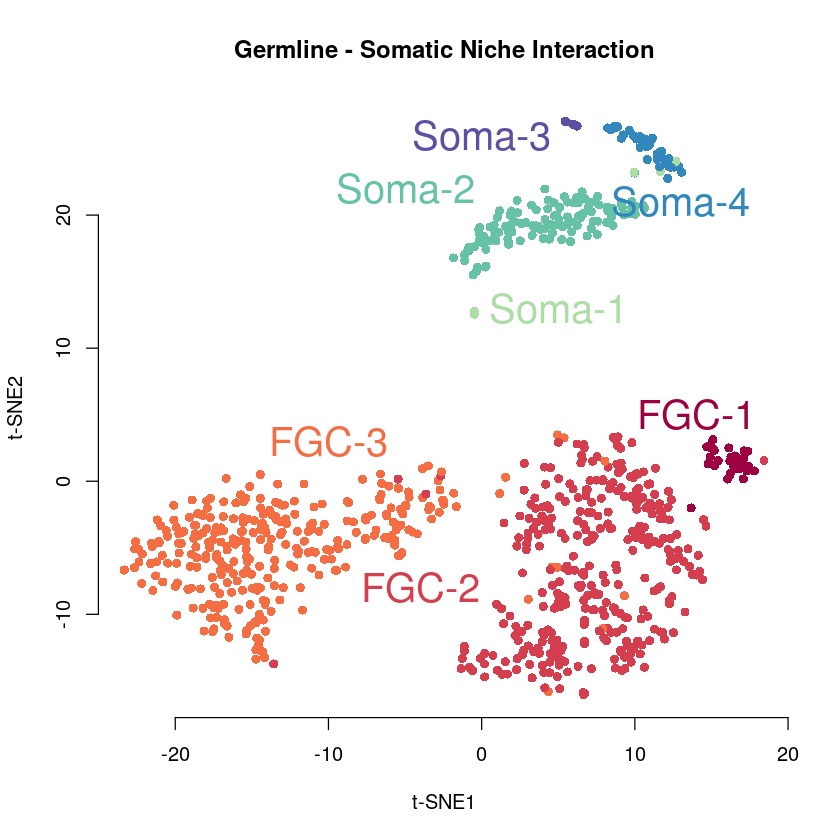

In [6]:
par(ask=FALSE)
plot(tsneGermMale$Y, col=labelGermMale,
	pch=16, main="Germline - Somatic Niche Interaction",
	xlab="t-SNE1", ylab="t-SNE2", bty="n")

text(14, 5, "FGC-1", col="#9E0142", cex=2)
text(-4, -8, "FGC-2", col="#D53E4F", cex=2)
text(-10, 3, "FGC-3", col="#F46D43", cex=2)
text(5, 13, "Soma-1", col="#ABDDA4", cex=2)
text(-5, 22, "Soma-2", col="#66C2A5", cex=2)
text(0, 26, "Soma-3", col="#5E4FA2", cex=2)
text(13, 21, "Soma-4", col="#3288BD", cex=2)

## 4. scTencorの実行

1. 発現量マトリックスのSingleCellExperiment　class化
2. （SingleCellExperiment　classに次元削減した二次元座標のデータを加える）
3. (遺伝子の発現量を正規化する)
4. リガンドー受容体ペアやラベル情報を追加する
5. 圧縮次元数パラメーターを決定する
6. 非負値テンソル分解を行う
7. HTML形式のレポートを出力する


### 1. 発現量マトリックスのSingleCellExperiment　class化  
GermMale（発現量matrix）は[SingleCellExperiment](https://bioconductor.org/packages/release/bioc/html/SingleCellExperiment.html) classにする必要がある。

In [7]:
sce <- SingleCellExperiment(assays=list(counts = GermMale))
sce

class: SingleCellExperiment 
dim: 242 852 
metadata(0):
assays(1): counts
rownames(242): 72 9510 ... 58189 7538
rowData names(0):
colnames(852): M_4W_embryo1_sc52 M_4W_embryo1_sc53 ...
  M_25W_embryo1_107_sc51 M_25W_embryo1_107_sc52
colData names(0):
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

### 2. SingleCellExperiment　classに次元削減した二次元座標のデータを加える
sceに次元削減した二次元座標のデータ（tsneGermMale）を加えると出力レポートが見やすくなるらしい。
reducedDimNamesにTSNEが追加される。

In [8]:
reducedDims(sce) <- SimpleList(TSNE=tsneGermMale$Y)
sce
head(reducedDims(sce)$TSNE)

class: SingleCellExperiment 
dim: 242 852 
metadata(0):
assays(1): counts
rownames(242): 72 9510 ... 58189 7538
rowData names(0):
colnames(852): M_4W_embryo1_sc52 M_4W_embryo1_sc53 ...
  M_25W_embryo1_107_sc51 M_25W_embryo1_107_sc52
colData names(0):
reducedDimNames(1): TSNE
spikeNames(0):
altExpNames(0):

M_4W_embryo1_sc52,16.27250,1.8273633
M_4W_embryo1_sc53,17.41540,1.1278984
M_4W_embryo1_sc54,16.20873,0.4803177
M_4W_embryo1_sc55,14.91489,1.8113621
M_4W_embryo1_sc56,14.90168,2.6814108
M_4W_embryo1_sc57,16.41085,1.1939982


### 3. 遺伝子の発現量を正規化する
[日本語の説明](https://colab.research.google.com/github/kokitsuyuzaki/SakigakeMTG2019/blob/master/exercise2/exercise2_scTensor.ipynb#scrollTo=PpV2es3c4q57)では、Count per Median (CPMED)正規化（細胞ごとの総発現量が、全細胞の総発現量の中央値になる）を行なっている。

In [9]:
CPMED <- function(input){
    libsize <- colSums(input) # sum gene expression in each cell
    median(libsize) * t(t(input) / libsize) 
}
normcounts(sce) <- log10(CPMED(counts(sce)) + 1) # add normcounts in assays(sce) to not over write non-normalized count
sce
head(assays(sce)$counts)
head(assays(sce)$normcounts)

class: SingleCellExperiment 
dim: 242 852 
metadata(0):
assays(2): counts normcounts
rownames(242): 72 9510 ... 58189 7538
rowData names(0):
colnames(852): M_4W_embryo1_sc52 M_4W_embryo1_sc53 ...
  M_25W_embryo1_107_sc51 M_25W_embryo1_107_sc52
colData names(0):
reducedDimNames(1): TSNE
spikeNames(0):
altExpNames(0):

,M_4W_embryo1_sc52,M_4W_embryo1_sc53,M_4W_embryo1_sc54,M_4W_embryo1_sc55,M_4W_embryo1_sc56,M_4W_embryo1_sc57,M_4W_embryo1_sc58,M_4W_embryo1_sc59,M_4W_embryo1_sc60,M_4W_embryo1_sc61,⋯,M_25W_embryo1_107_sc37,M_25W_embryo1_107_sc39,M_25W_embryo1_107_sc40,M_25W_embryo1_107_sc42,M_25W_embryo1_107_sc44,M_25W_embryo1_107_sc47,M_25W_embryo1_107_sc49,M_25W_embryo1_107_sc50,M_25W_embryo1_107_sc51,M_25W_embryo1_107_sc52
72,1078.47,683.13,685.63,198.07,1067.78,1566.38,326.22,1559.27,43.77,1099.96,⋯,0.00,32.63,49.58,0.00,39.29,40.42,33.36,1.69,47.06,1286.08
9510,4.49,0.00,0.00,0.00,0.00,0.00,1.29,13.72,0.00,0.00,⋯,0.00,0.00,26.52,42.53,0.00,0.00,0.00,0.00,2.94,0.00
11096,0.00,0.00,112.72,0.00,0.00,0.00,0.00,0.00,43.77,16.46,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
133,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.00,0.00,10.90,0.00,0.00,0.00,0.00,0.00,0.00
203,19.10,0.00,0.00,0.00,0.00,0.00,27.19,0.00,0.00,0.00,⋯,151.93,0.00,0.00,45.80,0.00,12.63,0.00,58.98,52.94,0.00
205,17.97,128.42,0.00,13.41,6.98,55.75,99.68,56.84,133.81,40.13,⋯,14.37,228.38,825.64,16.36,60.72,136.42,57.82,5.06,25.00,59.74


,M_4W_embryo1_sc52,M_4W_embryo1_sc53,M_4W_embryo1_sc54,M_4W_embryo1_sc55,M_4W_embryo1_sc56,M_4W_embryo1_sc57,M_4W_embryo1_sc58,M_4W_embryo1_sc59,M_4W_embryo1_sc60,M_4W_embryo1_sc61,⋯,M_25W_embryo1_107_sc37,M_25W_embryo1_107_sc39,M_25W_embryo1_107_sc40,M_25W_embryo1_107_sc42,M_25W_embryo1_107_sc44,M_25W_embryo1_107_sc47,M_25W_embryo1_107_sc49,M_25W_embryo1_107_sc50,M_25W_embryo1_107_sc51,M_25W_embryo1_107_sc52
72,3.372542,3.180208,3.129106,2.443883,3.1188225,3.542010,2.7537119,3.443081,1.948398,3.477690,⋯,0.000000,1.777100,1.668649,0.000000,1.397202,1.795183,1.843969,0.6408603,1.7689313,3.218885
9510,1.033941,0.000000,0.000000,0.000000,0.0000000,0.000000,0.5103906,1.404802,0.000000,0.000000,⋯,0.000000,0.000000,1.404941,1.709215,0.000000,0.000000,0.000000,0.0000000,0.6634365,0.000000
11096,0.000000,0.000000,2.346654,0.000000,0.0000000,0.000000,0.0000000,0.000000,1.948398,1.662157,⋯,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.0000000,0.000000
133,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,⋯,0.000000,0.000000,0.000000,1.141891,0.000000,0.000000,0.000000,0.0000000,0.0000000,0.000000
203,1.630864,0.000000,0.000000,0.000000,0.0000000,0.000000,1.6829512,0.000000,0.000000,0.000000,⋯,2.341932,0.000000,0.000000,1.740779,0.000000,1.305041,0.000000,2.0746121,1.8192414,0.000000
205,1.605017,2.455575,0.000000,1.295497,0.9817045,2.096723,2.2405461,2.008933,2.430406,2.043583,⋯,1.336264,2.615877,2.881289,1.307666,1.580066,2.318540,2.080181,1.0453808,1.5006950,1.891234


### 4. リガンドー受容体ペアやラベル情報を追加する

テンソル分解とHTMLレポートを実行するには、以下の情報はユーザーが指定する必要があるため、cellCellSetting()によって、SingleCellExperiment オブジェクトに情報を追加する。

- LRBase.XXX.eg.db : demoデータではLRBase.Hsa.eg.db
- 各セルの色ベクトル : demoデータではlabelGermMaleベクトルに色が登録してある
- 各セルのセルタイプベクトル: demoデータではlabelGermMaleの名前の部分

ここで、遺伝子x細胞xリガンドペアの３次元のデータが得られる。

In [10]:
cellCellSetting(sce, LRBase.Hsa.eg.db, labelGermMale, names(labelGermMale))

### 5. 圧縮次元数パラメーターを決定する
テンソル分解を行うcellCellDecomp（）を実行するには圧縮次元数を設定する必要がある。そこで、cellCellRanks()によって、リガンドー受容体のパターンを決定する。
ここでは、正規化した発現量を元に決定した。  
下のコマンドを実行した結果、4, 4となり、これの意味は、リガンドパターンが4つ、受容体パターンが4つに推定されたということ。  
(一回めやったときは、例と同様に4,3になったが、もう一度試したら4,4になった。)


In [11]:
rks <- cellCellRanks(sce, assayNames="normcounts")
rks$selected

Each rank, multiple NMF runs are performed
  |======================================================================| 100%
Each rank estimation method
  |======================================================================| 100%
Each rank, multiple NMF runs are performed
  |======================================================================| 100%
Each rank estimation method
  |======================================================================| 100%


[1] 4 4

### 6. 非負値テンソル分解を行う
cellCellRanks()によって推定されたパターンを指定して、非負値テンソル分解を行う。  
データテンソルが4つのリガンドパターンと4つの受容体パターンに分解される。

In [12]:
set.seed(1234)　#乱数を再現したい場合に設定する
cellCellDecomp(sce, ranks=rks$selected, assayNames="normcounts") # rks$selected = 4, 4

Input data matrix may contains 7 gene symbols because the name contains some alphabets.
scTensor uses only NCBI Gene IDs for now.
Here, the gene symbols are removed and remaining 235 NCBI Gene IDs are used for scTensor next step.

7 * 7 * 84 Tensor is created



### 7. HTML形式のレポートを出力する
tempdir()とするとRのセッションを閉じるときに削除されるファイルとして保存される？
out.dirのところに保存するディレクトリを指定する。


In [ ]:
d <- "/home/oba/scTensor"
cellCellReport(sce, reducedDimNames="TSNE", assayNames="normcounts",
    title="scTencor_demo",html.open=FALSE, upper=2, out.dir=d,
    goenrich=TRUE, meshenrich=FALSE, reactomeenrich=FALSE,
    doenrich=FALSE, ncgenrich=FALSE, dgnenrich=FALSE)
display_html(file=paste0(d, "/index.html"))

Using temporary cache /tmp/RtmplESdp0/BiocFileCache

Warning message:
"`select_()` is deprecated as of dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."
Warning message:
"`filter_()` is deprecated as of dplyr 0.7.0.
Please use `filter()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."
snapshotDate(): 2019-10-29

Using temporary cache /tmp/RtmplESdp0/BiocFileCache

Using temporary cache /tmp/RtmplESdp0/BiocFileCache

Using temporary cache /tmp/RtmplESdp0/BiocFileCache

Using temporary cache /tmp/RtmplESdp0/BiocFileCache

downloading 1 resources

retrieving 1 resource

Using temporary cache /tmp/RtmplESdp0/BiocFileCache

loading from cache

Using temporary cache /tmp/RtmplESdp0/BiocFileCache

Using temporary cache /tmp/RtmplESdp0/BiocFileCache

Using 

GO-Enrichment Analysis is running...(1/3)


Loading required package: org.Hs.eg.db



生成されたhtmlは[こちら](scTensor_demo_result/index.html)から見ることができます。